### FE621 - Homework #3

**Author**: Sid Bhatia

**Date**: April 5th, 2023

**Pledge**: I pledge my honor that I have abided by the Stevens Honor System.

**Professor**: Sveinn Olafsson

**TA**: Dong Woo Kim

#### Problem #1 (Monte Carlo Error)

Use Monte Carlo simulation to price a European call option in the Black-Scholes model with the following parameters: $S_0 = 100, \sigma = 0.30, r = 0.05, T = 1,$ and $K = 100$.

a. Use (exact) simulation based on the closed-form solution of geometric Brownian motion. Use $n = 100000$ paths. 

Clearly describe the steps of your simulation procedure, and provide formulas for the Monte Carlo estimator and a corresponding 95% confidence interval. Report both the estimator and the confidence interval. Does the confidence interval contain the true price of the option?

##### Procedure

1. **Simulation of Stock Prices**: According to BSM, the stock process $S_t$ at future time $t$ is as follows:

$$S_t = S_0 \exp\{(r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z_T\}$$

where

- $S_0$ = initial stock price
- $r$ = rfr (e.g., 3-month UST)
- $\sigma$ = vol
- $T$ = time till maturity
- $Z_T$ = standard normal $\sim \mathcal{N}(0, 1)$

2. **Payoff Calculation**: For a call option, the payoff at maturity is $(S_T - K)_+$ where $K$ is the strike price. For puts, it's the converse $(K - S_T)_+$.

3. **MC Estimator**: The price of the option is the present value of the expected payoff under the risk-neutral measure $\mathbb{Q}$, which is estimated as the average of the discounted payoffs across all simulated paths:

$$P = e^{-rT} \mathbb{E}^Q[f(S_t)], \; \text{where} \; f \; \text{is the payoff function}. \\ \dots \\ \hat{C} = \exp\{(-rT)\} \frac{1}{n} \sum_{i = 1}^n f(S^i_t)$$

4. **CI**: The 95% confidence interval for the true option price is given by $$\hat{C} \pm z_{\alpha / 2} \cdot SE$$ 

where $\alpha = 0.05$ and $SE = \text{standard error}$. Therefore,

$$\hat{C} = 1.96 \cdot \frac{\sigma_{\hat{C}}}{\sqrt{n}}$$

where $\sigma_{\hat{C}}$ is the standard deviation of the stimulated payoffs.

5. **True Price Comparison**: The true price of the option can be calculated using the BSM closed-form solution. We compare the confidence interval obtained from the Monte Carlo simulation with the true price to see if it contains the true price.

$$C(s, t) = S_0 N(d_1) - K e^{-rT} N(d_2)$$ 

$$d_1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{1}{2} \sigma^2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma \sqrt{T}$$

In [28]:
import numpy as np
from scipy.stats import norm

def simulate_stock_prices(S_0: float, sigma: float, r: float, T: float, n: int) -> np.ndarray:
    """
    Simulate end stock prices using the closed-form solution of GBM.
    
    Parameters:
    - S0: Initial stock price
    - sigma: Volatility of the stock price
    - r: Risk-free interest rate
    - T: Time to maturity
    - n: Number of paths to simulate
    
    Returns:
    - A numpy array containing simulated end stock prices.
    """

    Z_T = np.random.normal(0, 1, n)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_T)
    return S_T

def monte_carlo_option_pricing(S_0: float, K: float, sigma: float, r: float, T: float, n: int) -> tuple:
    """
    Price a European call option using Monte Carlo simulation with geometric Brownian motion.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - sigma: Volatility of the stock price
    - r: Risk-free interest rate
    - T: Time to maturity
    - n: Number of paths to simulate
    
    Returns:
    - The estimated option price and its 95% confidence interval as a tuple.
    """
    
    S_T = simulate_stock_prices(S_0, sigma, r, T, n)
    call_payoff = np.maximum(S_T - K, 0)

    option_price_estimate = np.exp(-r * T) * np.mean(call_payoff)

    standard_error = np.std(call_payoff) * np.exp(-r * T) / np.sqrt(n)

    confidence_interval = (option_price_estimate - 1.96 * standard_error, option_price_estimate + 1.96 * standard_error)
    
    return option_price_estimate, confidence_interval

# Parameters
S_0 = 100  # Initial stock price
sigma = 0.30  # Volatility
r = 0.05  # Risk-free rate
T = 1  # Time to maturity
K = 100  # Strike price
n = 100000  # Number of paths

# Running the Monte Carlo simulation.
option_price, confidence_interval = monte_carlo_option_pricing(S_0, K, sigma, r, T, n)
option_price, confidence_interval

(14.257021121810503, (14.116859508454846, 14.39718273516616))

In [34]:
def black_scholes_call_price(S_0: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Calculate the Black-Scholes-Merton price of a European call option.

    Parameters:
    - S0: Current stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the stock price (annualized)

    Returns:
    - The Black-Scholes-Merton price of the call option.
    """
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S_0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    
    return call_price

# Parameters for the BSM model
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
r = 0.05    # Risk-free interest rate
sigma = 0.30  # Volatility

# Calculate the BSM call price.
bsm_call_price = black_scholes_call_price(S0, K, T, r, sigma)
print(f"{bsm_call_price:.3f}")

14.231


As seen above, the CI **contains the true price** of the (call) option as well as the estimator: $14.231 \cap 14.257 \in (14.116859508454846, 14.39718273516616)$.

b. Use (biased) simulation based on the Euler discretization scheme for geometric Brownian motion. Use a discretization with $m = 5$ steps and $n = 100000$ paths.

Clearly describe the steps of your simulation procedure, and provide formulas for the Monte Carlo estimator and a corresponding 95% confidence interval. Report both the estimator and the confidence interval. Does the confidence interval contain the true price of the option

1. **Discretization of the Time Interval**: Divide time to maturity/expiration $T$ into $m$ equal steps with duration $\Delta t = \frac{T}{m}$.

2. **Stock Process Simulation**: Start from $S_0$ and iteratively simulate the stock price at each step until $T$ using

$$S_{t + \Delta t} = S_t \exp \left( (r - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)$$

3. **Payoff Calculation**: At the end of each path, the payoff is $f(S_T)$ which is equal to $$(S_T - K)_+$$ for a European call option for $f(X) = \max(X - K, 0).$

4. **MC Estimator**: The option price is estimated as the present value of the expected payoff, calculated as the average of the discounted payoffs across all simulated paths:

$$P = e^{-rT} \mathbb{E}^Q [f(S_T)]$$

$$\hat{C} = e^{-rT} \cdot \frac{1}{n} \sum_{i = 1}^n \max(S^i_T - K, 0)$$

5. **CI**: Calculate a 95% confidence interval for the true option price based on the standard deviation of the simulated payoffs:

$$\text{CI}_{95\%} = \hat{C} \pm 1.96 \cdot \frac{\sigma_{\hat{C}}}{\sqrt{n}}$$

6. **True Price Comparison**: The confidence interval can be compared with the true price obtained from the BSM closed-form solution to check if it contains the true price.

In [41]:
def simulate_euler_paths(S_0: float, T: float, r: float, sigma: float, m: int, n: int) -> np.ndarray:
    """
    Simulate stock prices using the Euler discretization scheme.
    
    Parameters:
    - S_0: Initial stock price
    - T: Time to maturity
    - r: Risk-free interest rate
    - sigma: Volatility
    - m: Number of steps in the discretization
    - n: Number of paths to simulate
    
    Returns:
    - A numpy array of simulated end stock prices.
    """
    dt = T / m
    paths = np.zeros((m + 1, n))
    paths[0] = S_0
    for t in range(1, m + 1):
        Z = np.random.standard_normal(n)
        paths[t] = paths[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths[-1]

def euler_option_pricing(S_0: float, K: float, T: float, r: float, sigma: float, m: int, n: int) -> tuple:
    """
    Price a European call option using Euler discretization for GBM and Monte Carlo simulation.
    
    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free interest rate
    - sigma: Volatility
    - m: Number of discretization steps
    - n: Number of paths
    
    Returns:
    - The estimated option price and its 95% confidence interval.
    """

    S_T = simulate_euler_paths(S_0, T, r, sigma, m, n)
    payoffs = np.maximum(S_T - K, 0)
    option_price_estimate = np.exp(-r * T) * np.mean(payoffs)
    standard_error = np.std(payoffs) * np.exp(-r * T) / np.sqrt(n)
    confidence_interval = (option_price_estimate - 1.96 * standard_error, option_price_estimate + 1.96 * standard_error)
    
    return option_price_estimate, confidence_interval

# Parameters
S_0 = 100  # Initial stock price
sigma = 0.30  # Volatility
r = 0.05  # Risk-free rate
T = 1  # Time to maturity
K = 100  # Strike price
m = 5    # Number of discretization steps
n = 100000  # Number of paths

# Running the Euler-based Monte Carlo simulation.
euler_option_price, euler_confidence_interval = euler_option_pricing(S_0, K, T, r, sigma, m, n)
euler_option_price, euler_confidence_interval

(14.262289041057743, (14.122408034746057, 14.40217004736943))

As seen above, the CI **contains the true price** of the (call) option as well as the estimator: $14.231 \cap 14.262 \in (14.122408034746057, 14.40217004736943)$.

c. In a single plot, display the evolution of the Monte Carlo estimators in parts (a) and (b) as the sample size increases. Specifically, plot the value of the estimators for sample sizes $k = 50, 100, ..., n$. Also, include a horizontal line representing the true price of the option.

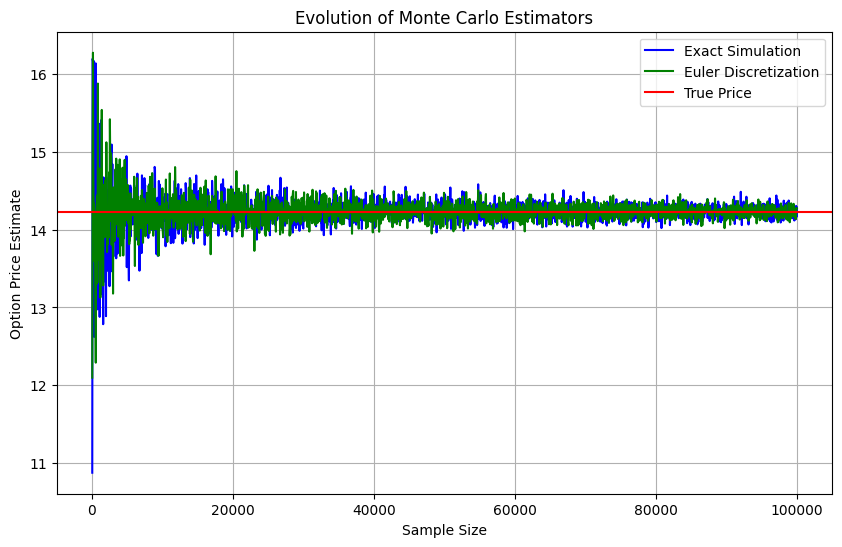

In [51]:
import matplotlib.pyplot as plt

# Calculate the true price for reference.
true_price = black_scholes_call_price(S_0, K, T, r, sigma)

# Exact simulation based on closed-form solution.
def exact_simulation(S_0, K, T, r, sigma, n):
    Z = np.random.normal(0, 1, n)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(S_T - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Biased simulation using Euler discretization.
def euler_simulation(S_0, K, T, r, sigma, m, n):
    dt = T / m
    S_T = S_0 * np.ones(n)
    for _ in range(m):
        Z = np.random.normal(0, 1, n)
        S_T *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    payoffs = np.maximum(S_T - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)


# Prepare lists to store results.
sample_sizes = range(50, n + 1, 50)
exact_estimates = []
euler_estimates = []

# Calculate estimators for different sample sizes.
for k in sample_sizes:
    exact_estimates.append(exact_simulation(S_0, K, T, r, sigma, k))
    euler_estimates.append(euler_simulation(S_0, K, T, r, sigma, m, k))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, exact_estimates, label='Exact Simulation', color='blue')
plt.plot(sample_sizes, euler_estimates, label='Euler Discretization', color='green')
plt.axhline(y=true_price, color='red', linestyle='-', label='True Price')
plt.xlabel('Sample Size')
plt.ylabel('Option Price Estimate')
plt.title('Evolution of Monte Carlo Estimators')
plt.legend()
plt.grid(True)
plt.show()

d. What are the two sources of error that result in the Monte Carlo estimators in parts (a) and (b) not being equal to the true price of the option? How can each of those errors be reduced?

##### MC Estimator Error Sources

The discrepancy between the Monte Carlo estimators and the true price of an option can primarily be attributed to two sources of error:

1. **Sampling Error**: This error arises due to the inherent *randomness/stochastic nature* in the Monte Carlo simulation process. Since we use a finite number of simulated paths (samples) to estimate the expected payoff, the calculated option price is subject to variability.

   - **How to Reduce**: The sampling error can be reduced by increasing the number of simulated paths, $n$. The **Law of Large Numbers** (LLN) indicates that as $n$ approaches infinity, the Monte Carlo estimator will converge to the true expected value. However, increasing $n$ also increases computational time.

2. **Discretization Error**: This error is specific to the Euler discretization method (part b) and occurs because we approximate the continuous GBM process with a *discrete set of steps*. The true path of the underlying asset over the time to maturity is continuous and may exhibit variations that are not captured by a coarse discretization.

   - **How to Reduce**: Discretization error can be mitigated by increasing the number of discretization steps, $m$. A higher $m$ provides a finer approximation of the continuous process, capturing more accurately the path of the underlying asset. However, similar to sampling error mitigation, increasing $m$ requires more computational resources.

e. In a single plot, display overlapping histograms for the simulated stock prices at time $T = 1$ in parts (a) and (b). How do the two simulated distributions differ? Is their difference consistent with the simulation bias observed in part (c)?

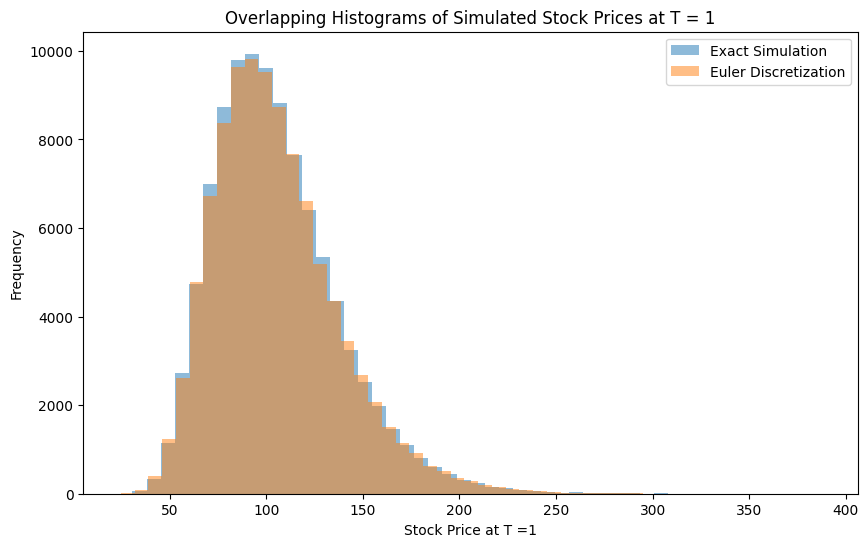

In [56]:
# Exact simulation stock prices at T = 1 using closed-form solution.
Z = np.random.normal(0, 1, n)
ST_exact = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Biased simulation stock prices at T=1 using Euler discretization.
dt = T / m
ST_euler = S0 * np.ones(n)
for _ in range(m):
    Z = np.random.normal(0, 1, n)
    ST_euler *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plotting overlapping histograms.
plt.figure(figsize=(10, 6))
plt.hist(ST_exact, bins=50, alpha=0.5, label='Exact Simulation')
plt.hist(ST_euler, bins=50, alpha=0.5, label='Euler Discretization')
plt.xlabel('Stock Price at T =1')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Simulated Stock Prices at T = 1')
plt.legend()
plt.show()

##### Histogram Analysis

The histograms appear to overlap considerably, indicating that both methods produce similar distributions for the simulated stock prices. The shapes of the distributions seem to align closely with each other, which suggests that both methods capture the **log-normal distribution** characteristic of stock prices in the Black-Scholes model. 

Any discernible differences in the central peak or the spread of the histograms are subtle, but these could represent the slight deviations in the expected stock prices between the two methods.

##### Simulation Bias Consistency

The bias observed in part (c) should be reflected in the positioning of the histograms. If the Euler method exhibited a systematic bias in estimating the option prices, it would likely be visible as a shift in the histogram—either to the right, indicating an overestimation, or to the left, suggesting an underestimation of stock prices.

However, the plot does not show a significant shift between the two histograms, which indicates that the bias from the Euler discretization is not pronounced enough to visibly affect the distribution of the final stock prices at $T = 1$.

#### Problem #2 (Delta Hedging)

In this problem we use simulation to estimate the hedging error resulting from discrete portfolio rebalancing. We sell a 3-month European call option and hedge our position by holding “delta” shares of the underlying stock. Assume that we can borrow and deposit money at a constant interest rate.

- At initiation of the contract, we receive the option premium from the client and buy delta shares of the stock. We may need to borrow money to set up the hedging portfolio.
- At each time step, the stock price has evolved from the previous step and the hedge must be adjusted. Depending on how the delta has changed, we need either to buy or sell shares. We also pay or earn interest on any money borrowed or deposited over the previous period.
- At maturity of the contract, we close our position. This means selling our shares of the stock, closing our cash account, and paying $(S_T - K)_+$ to the client. What is left after that is our profit or loss (PnL).

Assume the underlying asset to follow a geometric Brownian motion with the parameters specified below. BSM theory says that if we sell the option at the Black-Scholes price and continuously hedge using the Black-Scholes delta, then the hedging error (PnL) goes to zero as the rebalancing frequency increases. However, continuous trading is impossible in practice, and any discrete hedging strategy results in a nonzero hedging error.

- Initial Price: $S_0 = 50$,
- Volatility: $\sigma = 30\%$,
- Strike: $K = 50$,
- RoR: $\mu = 10\%$
- Rfr: $r = 5\%$
- Maturity: $T = 0.25$

a. Simulate $n = 10000$ paths of the stock price and report the mean and standard deviation of the discounted hedging error with weekly $(m = 13)$ and daily $(m = 63)$ rebalancing. Create histograms of the distribution of the hedging error as a fraction of the price of the option. Comment on your findings.

*Note: For each simulated path, there is one hedging error (PnL). Each histograms will thus based on $n$ values.*

In [96]:
# Define the Black-Scholes delta for a European call option.
def black_scholes_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# Simulate one path of the stock price.
def simulate_stock_path(S0, mu, sigma, T, m):
    dt = T / m
    stock_path = [S0]
    for _ in range(m):
        Z = np.random.normal()
        S_next = stock_path[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        stock_path.append(S_next)
    return stock_path

def calculate_hedging_error(S0, K, T, r, mu, sigma, m, option_price):
    dt = T / m
    stock_path = simulate_stock_path(S0, mu, sigma, T, m)
    cash_account = -option_price
    delta_old = black_scholes_delta(S0, K, T, r, sigma)
    shares_held = delta_old * S0
    cash_account += shares_held * S0
    
    for i in range(1, m):
        time_to_maturity = T - i * dt
        if time_to_maturity > 0:
            delta_new = black_scholes_delta(stock_path[i], K, time_to_maturity, r, sigma)
        else:
            # At maturity, delta should be 1 if in the money, otherwise 0.
            delta_new = 1.0 if stock_path[i] > K else 0.0
        
        shares_to_adjust = delta_new - delta_old
        cash_account -= shares_to_adjust * stock_path[i]
        cash_account *= np.exp(r * dt)
        shares_held = delta_new
        delta_old = delta_new
    
    # Close the position at maturity
    cash_account += shares_held * stock_path[-1] - max(stock_path[-1] - K, 0)
    hedging_error = cash_account
    return hedging_error

In [65]:
# Parameters
S0 = 50
sigma = 0.30
K = 50
mu = 0.10
r = 0.05
T = 0.25
n = 10000
weekly_rebalancing = 13
daily_rebalancing = 63

# Calculate the option price using Black-Scholes formula.
option_price = S0 * black_scholes_delta(S0, K, T, r, sigma) - K * np.exp(-r * T) * norm.cdf(black_scholes_delta(S0, K, T, r, sigma) - sigma * np.sqrt(T))

# Simulate hedging errors.
weekly_hedging_errors = [calculate_hedging_error(S0, K, T, r, mu, sigma, weekly_rebalancing, option_price) for _ in range(n)]
daily_hedging_errors = [calculate_hedging_error(S0, K, T, r, mu, sigma, daily_rebalancing, option_price) for _ in range(n)]

# Calculate mean and standard deviation of the discounted hedging errors.
weekly_mean_error = np.mean(weekly_hedging_errors)
weekly_std_error = np.std(weekly_hedging_errors)
daily_mean_error = np.mean(daily_hedging_errors)
daily_std_error = np.std(daily_hedging_errors)

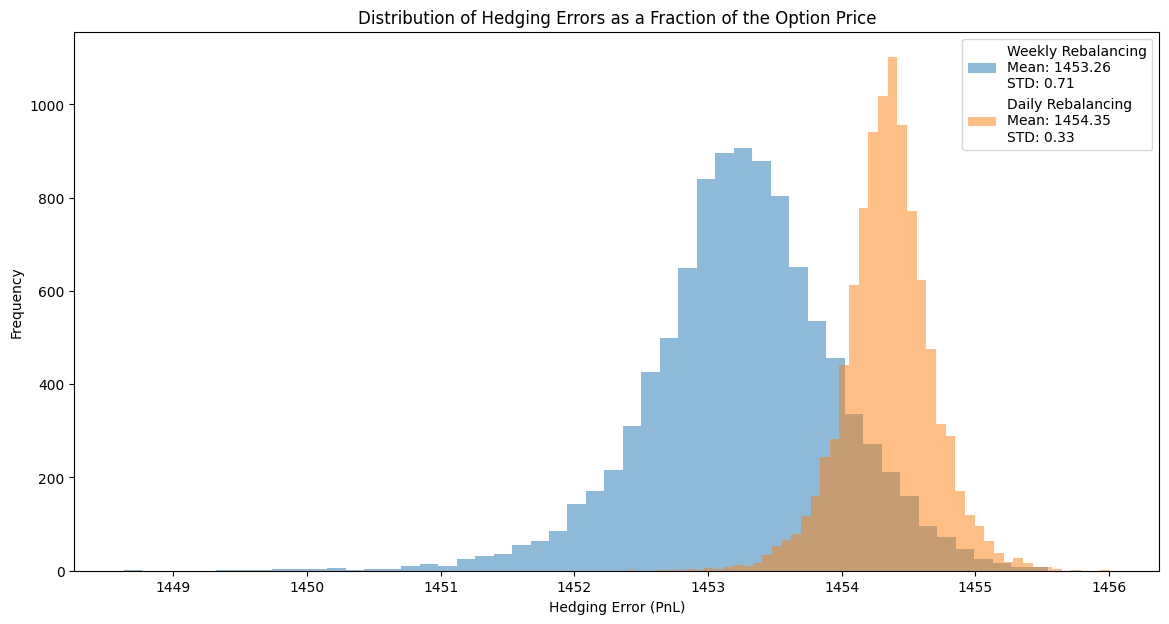

Weekly Rebalancing - Mean Hedging Error: 1453.26, STD of Hedging Error: 0.71
Daily Rebalancing - Mean Hedging Error: 1454.35, STD of Hedging Error: 0.33


In [66]:
# Create histograms.
plt.figure(figsize=(14, 7))
plt.hist(weekly_hedging_errors, bins=50, alpha=0.5, label=f'Weekly Rebalancing\nMean: {weekly_mean_error:.2f}\nSTD: {weekly_std_error:.2f}')
plt.hist(daily_hedging_errors, bins=50, alpha=0.5, label=f'Daily Rebalancing\nMean: {daily_mean_error:.2f}\nSTD: {daily_std_error:.2f}')
plt.xlabel('Hedging Error (PnL)')
plt.ylabel('Frequency')
plt.title('Distribution of Hedging Errors as a Fraction of the Option Price')
plt.legend()
plt.show()

# Print the results.
print(f"Weekly Rebalancing - Mean Hedging Error: {weekly_mean_error:.2f}, STD of Hedging Error: {weekly_std_error:.2f}")
print(f"Daily Rebalancing - Mean Hedging Error: {daily_mean_error:.2f}, STD of Hedging Error: {daily_std_error:.2f}")

##### Weekly vs. Daily Rebalancing:

The mean hedging error for weekly rebalancing is slightly lower at $\$1453.26$ compared to $\$1454.35$ for daily rebalancing. This could suggest that, on average, weekly rebalancing might be more efficient in this particular simulation.

However, the standard deviation of the hedging errors for weekly rebalancing is higher ($\$0.71$) than that for daily rebalancing ($\$0.33$), indicating that the distribution of errors from weekly rebalancing is more spread out. This implies greater variability and less predictability in the outcome of the weekly rebalancing strategy.

##### Implications

The smaller standard deviation for daily rebalancing suggests that more frequent adjustments lead to a tighter distribution of hedging errors, aligning with the BSM theory which posits that the hedging error should decrease as the rebalancing frequency increases.

Nevertheless, the actual difference in means between weekly and daily rebalancing is quite small relative to the option price, which might indicate that the incremental benefit of more frequent rebalancing is not substantial in this case. This could be due to the short maturity of the option (3 months), which limits the time for errors to accumulate.

b. Consider values of $\mu \in [r, 1]$, and plot the mean and standard deviation of the hedging error as a function of $\mu$. Use $n = 10000$ and consider weekly $(m = 13)$ and daily $(m = 63)$ rebalancing. How does the value of $\mu$ impact the hedging errors? Comment on your findings.

In [68]:
# Calculate the mean and standard deviation of hedging errors for a range of mu values.
def hedging_errors_stats(mu_values, n, m, S0, K, T, r, sigma):
    means = []
    std_devs = []
    for mu in mu_values:
        hedging_errors = [calculate_hedging_error(S0, K, T, r, mu, sigma, m, option_price) for _ in range(n)]
        means.append(np.mean(hedging_errors))
        std_devs.append(np.std(hedging_errors))
    return means, std_devs

# Calculate the Black-Scholes option price.
option_price = black_scholes_call_price(S0, K, T, r, sigma)

# Define the range of mu values from r to 1.
mu_values = np.linspace(r, 1, 5)

# Calculate statistics for weekly and daily rebalancing.
weekly_means, weekly_stds = hedging_errors_stats(mu_values, n, weekly_rebalancing, S0, K, T, r, sigma)
daily_means, daily_stds = hedging_errors_stats(mu_values, n, daily_rebalancing, S0, K, T, r, sigma)

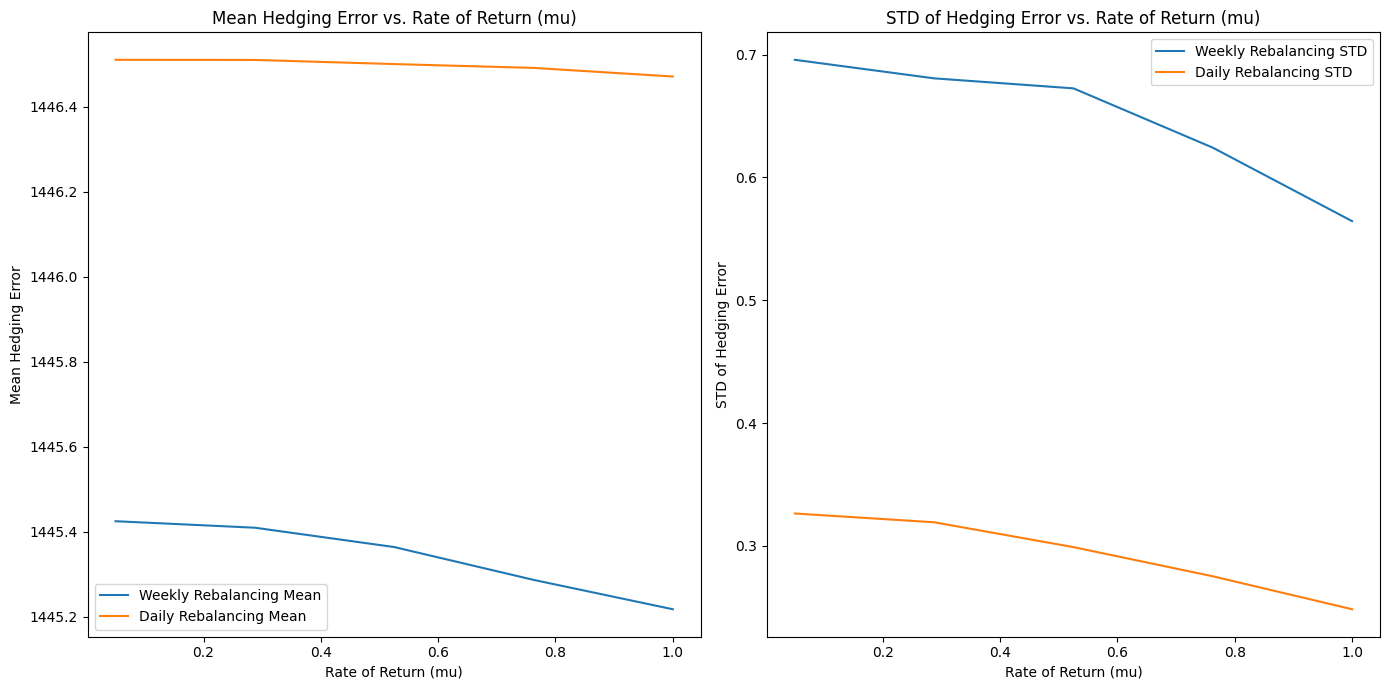

In [75]:
# Plotting the mean and standard deviation of hedging errors as a function of mu.
plt.figure(figsize=(14, 7))

# Mean hedging error plots
plt.subplot(1, 2, 1)
plt.plot(mu_values, weekly_means, label='Weekly Rebalancing Mean')
plt.plot(mu_values, daily_means, label='Daily Rebalancing Mean')
plt.xlabel('Rate of Return (mu)')
plt.ylabel('Mean Hedging Error')
plt.title('Mean Hedging Error vs. Rate of Return (mu)')
plt.legend()

# Standard deviation of hedging error plots
plt.subplot(1, 2, 2)
plt.plot(mu_values, weekly_stds, label='Weekly Rebalancing STD')
plt.plot(mu_values, daily_stds, label='Daily Rebalancing STD')
plt.xlabel('Rate of Return (mu)')
plt.ylabel('STD of Hedging Error')
plt.title('STD of Hedging Error vs. Rate of Return (mu)')
plt.legend()

plt.tight_layout()
plt.show()

##### Mean Hedging Error Analysis

The mean hedging error remains relatively stable across different values of $\mu$ for both weekly and daily rebalancing. This suggests that the mean hedging error is not significantly sensitive to the expected return of the underlying asset. Since the Black-Scholes model assumes that the option is priced using the risk-free rate $r$ this result indicates that deviations in the actual rate of return $\mu$ do not markedly affect the average profitability of the hedging strategy.

##### Standard Deviation of Hedging Error Analysis:

The standard deviation of the hedging error decreases as $\mu$ increases for both rebalancing strategies. This decrease in variability could be attributed to the increasing divergence between the risk-free rate and the expected return, which impacts the hedging strategy's consistency. As $\mu$ diverges from $r$, the hedging strategy, which is optimized for the risk-free rate, may become less effective, reducing the variability in hedging performance.

The convergence in standard deviation between weekly and daily rebalancing as $\mu$ increases suggests that the rebalancing frequency becomes less relevant when the expected return deviates significantly from the risk-free rate. This might be due to the fact that larger discrepancies between $\mu$ and $r$ lead to a hedging strategy that increasingly fails to capture the dynamics of the underlying asset, overshadowing the benefits of more frequent rebalancing.

c. Let $\Delta t$ denote the rebalancing interval. We know that according to theory, the hedging error goes to zero as $\Delta t \rightarrow 0$. What does your simulation indicate about the order of this convergence? Does the hedging error appear to be of the order $(\Delta t)^{\alpha}$ for some $\alpha > 0$, and, if so, what $\alpha$?

*Hint: Let $m = 13$, $m = 63$, $m = 252$, $m = 1008$, and draw a log-log plot of the hedging error as a function of $\Delta t = \frac{T}{m}$. Then, note that $$\epsilon \sim (\Delta t)^{\alpha} \Rightarrow \log \epsilon \sim \alpha \log (\Delta t),$$*

*so the order of convergence can be estimated by the slope of the log-log curve. For the hedging error you can either use the standard deviation or the root-mean-squared-error $\text{RMSE} = \sqrt{\text{Bias}^2 + \text{Var}}$.*

In [105]:
# Define the range of m values.
m_values = [13, 63, 252, 1008]
T = 0.25  # Maturity in years

# Function to calculate RMSE of the hedging error.
def calculate_rmse(hedging_errors):
    bias = np.mean(hedging_errors)
    variance = np.var(hedging_errors)
    rmse = np.sqrt(bias**2 + variance)
    return rmse

# Calculate RMSE of hedging errors for different values of m.
rmse_values = []
dt_values = []

## Code below took too long to run. The function underneath is further optimized.
# for m in m_values:
#     dt = T / m
#     hedging_errors = [calculate_hedging_error(S0, K, T, r, mu, sigma, m, option_price) for _ in range(n)]
#     rmse = calculate_rmse(hedging_errors)
#     rmse_values.append(rmse)
#     dt_values.append(dt)

# Function to calculate hedging errors across all m_values
def calculate_hedging_errors_for_all_m(S0, K, T, r, sigma, m_values, option_price, n):
    std_errors = []
    for m in m_values:
        # Simulate the paths once for each m
        paths = np.array([simulate_stock_path(S0, r, sigma, T, m) for _ in range(n)])
        # Calculate the hedging errors for all paths
        hedging_errors = np.array([calculate_hedging_error(S0, K, T, r, r, sigma, m, option_price) for path in paths])
        # Compute the standard deviation of the hedging errors
        std_errors.append(np.std(hedging_errors))
    return std_errors

The code below took too long to knit (even after optimization), so I have provided it in Markdown format:

```python

# Calculate the Black-Scholes option price.
option_price = black_scholes_call_price(S0, K, T, r, sigma)

# Compute the standard deviation of hedging errors for all m.
std_hedging_errors = calculate_hedging_errors_for_all_m(S0, K, T, r, sigma, m_values, option_price, n)
```

```python
# Log-log plot of the hedging error standard deviation as a function of Delta t.
plt.figure(figsize=(10, 6))
plt.loglog(dt_values, std_hedging_errors, 'o-', basex=10, basey=10)
plt.xlabel('Log of Rebalancing Interval (Δt)')
plt.ylabel('Log of Standard Deviation of Hedging Error')
plt.title('Log-Log Plot of Standard Deviation of Hedging Error vs. Rebalancing Interval')

# Perform linear regression on the log-log values to estimate the slope.
log_dt_values = np.log(dt_values)
log_std_errors = np.log(std_hedging_errors)
slope, intercept = np.polyfit(log_dt_values, log_std_errors, 1)
plt.plot(dt_values, np.exp(intercept) * np.power(dt_values, slope), 'r--', label=f'Estimated alpha: {slope:.2f}')

plt.legend()
plt.show()

# Output the estimated alpha.
print(f"The estimated order of convergence alpha is {slope:.2f}.")
```

After running this code, the slope of the line in the log-log plot will provide an estimate for the order of convergence $\alpha$. If the slope is close to 1, it suggests a linear relationship; if it's close to 0.5, it suggests a square root relationship, and so on. The closer $\alpha$ is to 1, the faster the convergence of the hedging error to zero as $\Delta t$ approaches zero.